# Chemprot Shortcut analysis

In [1]:
s3_test_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_test.json"
s3_train_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_train.json"
s3_val_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_dev.json"

#### Get the gold dataset from https://biocreative.bioinformatics.udel.edu/media/store/files/2017/ChemProt_Corpus.zip

In [2]:
test_gold_file = "../temp/data/chemprot_test_gold_standard.tsv"

In [3]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")


label_names = ["NEGATIVE",
                            "CPR:3",
                            "CPR:4",
                            "CPR:5",
                            "CPR:6",
                            "CPR:9"]

all_labels = list(range(len(label_names)))
pos_labels = list(range(1, len(label_names)))

trigger_words =  ["induced", "activator","upregulator" , "inhibitor","downregulator" , "agonist", "kinase","regulator","modulator"]



In [4]:
import sys, os, pandas as pd
sys.path.append("../src")

from utils.s3_utils import download_file as download_s3_file

## Download prediction

In [5]:
local_temp= "temp"

In [6]:
local_prediction_dir = os.path.join(local_temp, "prediction")
os.makedirs(local_prediction_dir, exist_ok=True)
local_test_prediction_file  = download_s3_file( s3_test_prediction, local_prediction_dir)
local_train_prediction_file  = download_s3_file( s3_train_prediction, local_prediction_dir)
local_val_prediction_file  = download_s3_file( s3_val_prediction, local_prediction_dir)




## Utils

In [7]:
def add_key_column(df):
    df["key"] = df.apply(lambda x:"{}#{}#{}".format( x["abstract_id"], x["participant1_id"].replace("Arg1:",""), x["participant2_id"].replace("Arg2:","")), axis=1)
    return df

def load_gold(file):
    df = pd.read_csv(file, delimiter="\t", header=None, names = ["abstract_id", "relationship_type", "participant1_id","participant2_id"])
    
    return df

In [8]:


def load_valtest_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x))
    df["y_raw"] = df["prediction"]


    df["x"] = df["sentence_anonymised"].apply(lambda x: x.replace("_GENE-Y_", "_GENE_")
                                                                .replace("_GENE-N_", "_GENE_"))
    df["gold"] = df["label"].apply(lambda x: labels_order.index(x))
    df["gold_raw"] = df["label"]


    #df = df.query("is_eval == 'Y'").copy()

    return df

In [9]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"

def  train_and_predict_all_classifiers(df, min_df=None):
    max_words_per_class=100
    
    classifiers = {
        NAIVE_BAYES : ModelNBRelationClassifier("_CHEMICAL_", "_GENE_", min_df=min_df, max_words_per_class=max_words_per_class),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("_CHEMICAL_", "_GENE_", min_df=min_df,  max_words_per_class=max_words_per_class,trigger_words=trigger_words),
        TREE : ModelTreeRelationClassifier("_CHEMICAL_", "_GENE_", trigger_words=trigger_words)

    }
    
    result = {}
    for k, m in classifiers.items():
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        result[k] = {
            "m" : m,
            "predictions" : m.predict(df["x"])[0]
        }
    return result




In [10]:
import tempfile

def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False

def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, labels=None, label_names = all_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
    
    
  
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))

    return df
    

def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    df.insert(1, "index", df.index)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df    
    

In [11]:
    
import subprocess

def _write_chemprot_eval(df,y_col, dest_file):
    df = df[["abstract_id",y_col, "participant1_id", "participant2_id"]].query(f"{y_col} != 'NEGATIVE' ").copy(deep=True)
    

    df["participant1_id"] = df["participant1_id"].apply(lambda x: f"Arg1:{x}")
    df["participant2_id"] = df["participant2_id"].apply(lambda x: f"Arg2:{x}")
    df.to_csv(dest_file, sep="\t", header=False, index=False)

    
def _run_shell( cmd):
        """
        Runs a shell command
        :param cmd: The cmd to run
        """
        print("Running command\n{}".format(" ".join(cmd)))

        out = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT)
        stdout, stderr = out.communicate()
        result = stdout.decode(encoding='utf-8')
        if stderr:
            error_msg = stderr.decode(encoding='utf-8')
            print(error_msg)
            raise Exception(error_msg)

        return result
    
def print_report_original(df,y_col, gold_file, latex=True,  jar_path="../thirdparty"):
    # Run original eval script to double check numbers
    _, pred_file = tempfile.mkstemp()
    _write_chemprot_eval(df,y_col, pred_file)
    output_dir = "out"
    os.makedirs(output_dir, exist_ok = True)
    cmd = ["java", "-cp" , f"{jar_path}/bc6chemprot_eval.jar", "org.biocreative.tasks.chemprot.main.Main",
           "-TP", "TRUE", "-FP", "TRUE", "-FN", "TRUE", pred_file, gold_file]
    cmd_result = _run_shell(cmd)
    print(cmd_result)

    # Result summary written to eval .txt
    with open(os.path.join(output_dir,"eval.txt"), "r") as f:
        result = f.readlines()
        print(result)
        
    # Parse detailed output file to obtain classwise stats
    names = ["abstract_id", "y", "participant1_id", "participant2_id"]
    df_fp = pd.read_csv(os.path.join(output_dir,"fp.txt"),sep="\t", header=None, names=names)
    df_fp["c"] ="FP"
    df_fn = pd.read_csv(os.path.join(output_dir,"fn.txt"),sep="\t", header=None, names=names)
    df_fn["c"] ="FN"
    df_tp = pd.read_csv(os.path.join(output_dir,"tp.txt"),sep="\t", header=None, names=names)
    df_tp["c"] ="TP"
    df = pd.concat([df_fp, df_tp, df_fn])
    
    df_test_summary = df.groupby(["y" , "c"]).size()\
                .reset_index().rename(columns={0:"total"})\
                .pivot(index="y", columns="c", values="total")
    df_test_summary.loc["total", "FN"] = df_test_summary["FN"].sum()
    df_test_summary.loc["total", "FP"] = df_test_summary["FP"].sum()
    df_test_summary.loc["total", "TP"] = df_test_summary["TP"].sum()

    df_test_summary["P"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FP"])
    df_test_summary["R"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FN"])
    df_test_summary["F"] = (2*df_test_summary["P"] * df_test_summary["R"]).div(df_test_summary["P"] +df_test_summary["R"])


    
    # Clean up
    os.remove(pred_file)
    return df_test_summary

In [12]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [13]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [15]:
def filter_eval(df):
    return df[df["is_eval"].apply(lambda r: r == 'Y')].copy() 

## Train GT Train predictions

In [16]:
df_train = load_valtest_pred(local_train_prediction_file)


train_result = train_and_predict_all_classifiers(df_train, min_df=1)



print_report_all_classifiers(df_train["gold"],train_result, labels=pos_labels)

Training Naive Bayes
Max words :  391
Training Naive Bayes + Tree
(6414, 14)
(6414, 14)
Training Tree
(6414, 13)
(6414, 13)
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      46.0 &   67.8 &     54.8 &     774 \\
       Naive Bayes &            2 &      76.3 &   66.3 &     70.9 &    2251 \\
       Naive Bayes &            3 &      73.7 &   75.9 &     74.8 &     170 \\
       Naive Bayes &            4 &      69.1 &   86.9 &     77.0 &     229 \\
       Naive Bayes &            5 &      68.3 &   65.2 &     66.7 &     727 \\
       Naive Bayes &    micro avg &      66.3 &   67.9 &     67.1 &    4151 \\
       Naive Bayes &    macro avg &      66.7 &   72.4 &     68.8 &    4151 \\
       Naive Bayes & weighted avg &      68.7 &   67.9 &     67.7 &    4151 \\
Naive Bayes + Tree &            1 &      46.1 &   68.0 &     54.9 &     774 \\
Naive Bayes + Tree &            2 &      75.

,model,index,precision,recall,f1-score,support
1,Naive Bayes,1,0.459720,0.678295,0.548017,774.0
2,Naive Bayes,2,0.762781,0.662817,0.709294,2251.0
3,Naive Bayes,3,0.737143,0.758824,0.747826,170.0
4,Naive Bayes,4,0.690972,0.868996,0.769826,229.0
5,Naive Bayes,5,0.682997,0.651994,0.667136,727.0
micro avg,Naive Bayes,micro avg,0.662515,0.679113,0.670711,4151.0
macro avg,Naive Bayes,macro avg,0.666723,0.724185,0.688420,4151.0
weighted avg,Naive Bayes,weighted avg,0.687287,0.679113,0.676756,4151.0
1,Naive Bayes + Tree,1,0.460595,0.679587,0.549061,774.0
2,Naive Bayes + Tree,2,0.750000,0.679698,0.713120,2251.0


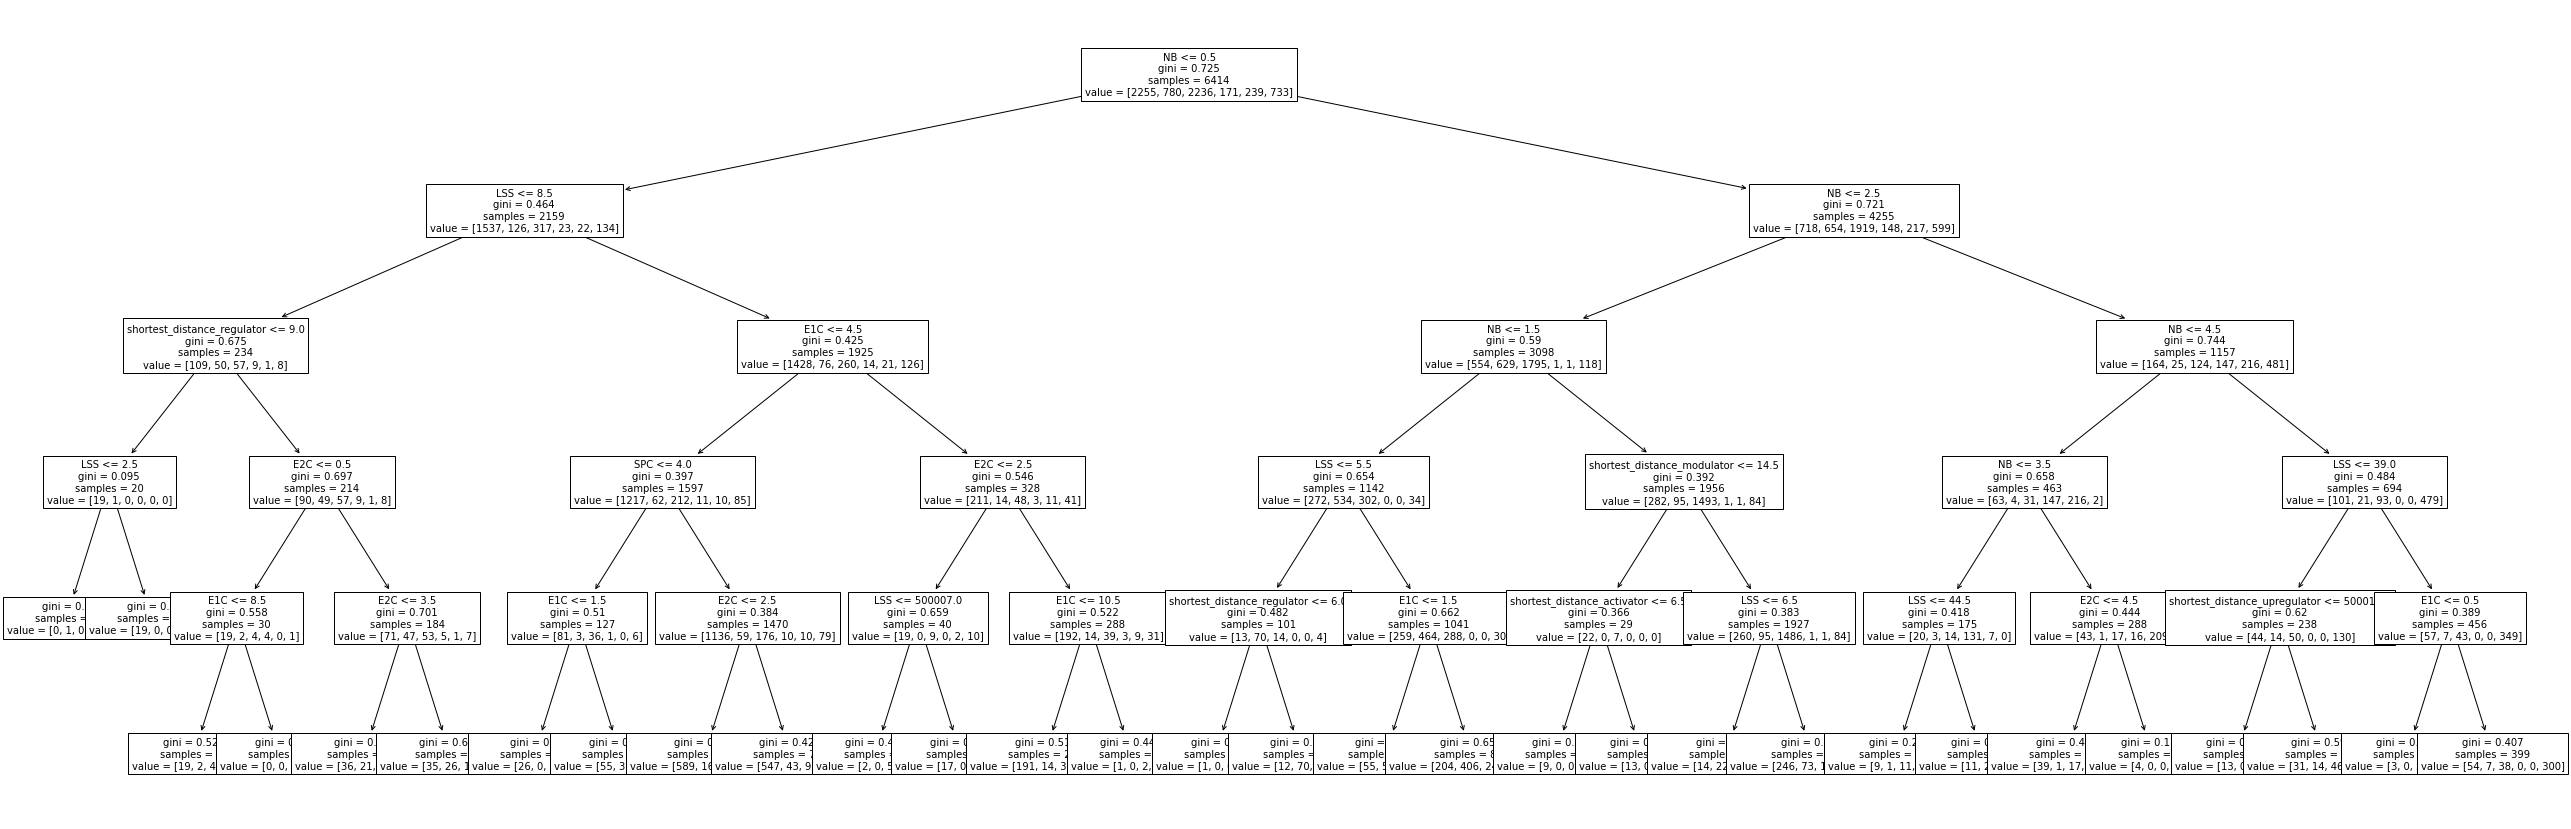

In [17]:
plot_tree(train_result[NAIVE_BAYES_WITH_TREE]["m"])



## Val GT predictions


In [18]:
df_val = load_valtest_pred(local_val_prediction_file)


val_result = train_and_predict_all_classifiers(df_val, min_df=1)




print_report_all_classifiers(df_val["gold"],val_result, labels=pos_labels)

Training Naive Bayes
Max words :  459
Training Naive Bayes + Tree
(3550, 14)
(3550, 14)
Training Tree
(3550, 13)
(3550, 13)
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      49.1 &   66.9 &     56.7 &     550 \\
       Naive Bayes &            2 &      70.7 &   73.4 &     72.0 &    1102 \\
       Naive Bayes &            3 &      70.7 &   75.0 &     72.8 &     116 \\
       Naive Bayes &            4 &      76.7 &   87.4 &     81.7 &     199 \\
       Naive Bayes &            5 &      85.0 &   49.7 &     62.7 &     455 \\
       Naive Bayes &    micro avg &      66.3 &   68.7 &     67.5 &    2422 \\
       Naive Bayes &    macro avg &      70.4 &   70.5 &     69.2 &    2422 \\
       Naive Bayes & weighted avg &      69.0 &   68.7 &     67.6 &    2422 \\
Naive Bayes + Tree &            1 &      49.9 &   67.1 &     57.2 &     550 \\
Naive Bayes + Tree &            2 &      71.

,model,index,precision,recall,f1-score,support
1,Naive Bayes,1,0.491322,0.669091,0.566590,550.0
2,Naive Bayes,2,0.707168,0.734120,0.720392,1102.0
3,Naive Bayes,3,0.707317,0.750000,0.728033,116.0
4,Naive Bayes,4,0.766520,0.874372,0.816901,199.0
5,Naive Bayes,5,0.849624,0.496703,0.626907,455.0
micro avg,Naive Bayes,micro avg,0.663212,0.687036,0.674914,2422.0
macro avg,Naive Bayes,macro avg,0.704390,0.704857,0.691765,2422.0
weighted avg,Naive Bayes,weighted avg,0.689798,0.687036,0.676199,2422.0
1,Naive Bayes + Tree,1,0.498649,0.670909,0.572093,550.0
2,Naive Bayes + Tree,2,0.715939,0.729583,0.722697,1102.0


Training Naive Bayes
Max words :  459
Training Naive Bayes + Tree
(3550, 14)
(3550, 14)
Training Tree
(3550, 13)
(3550, 13)


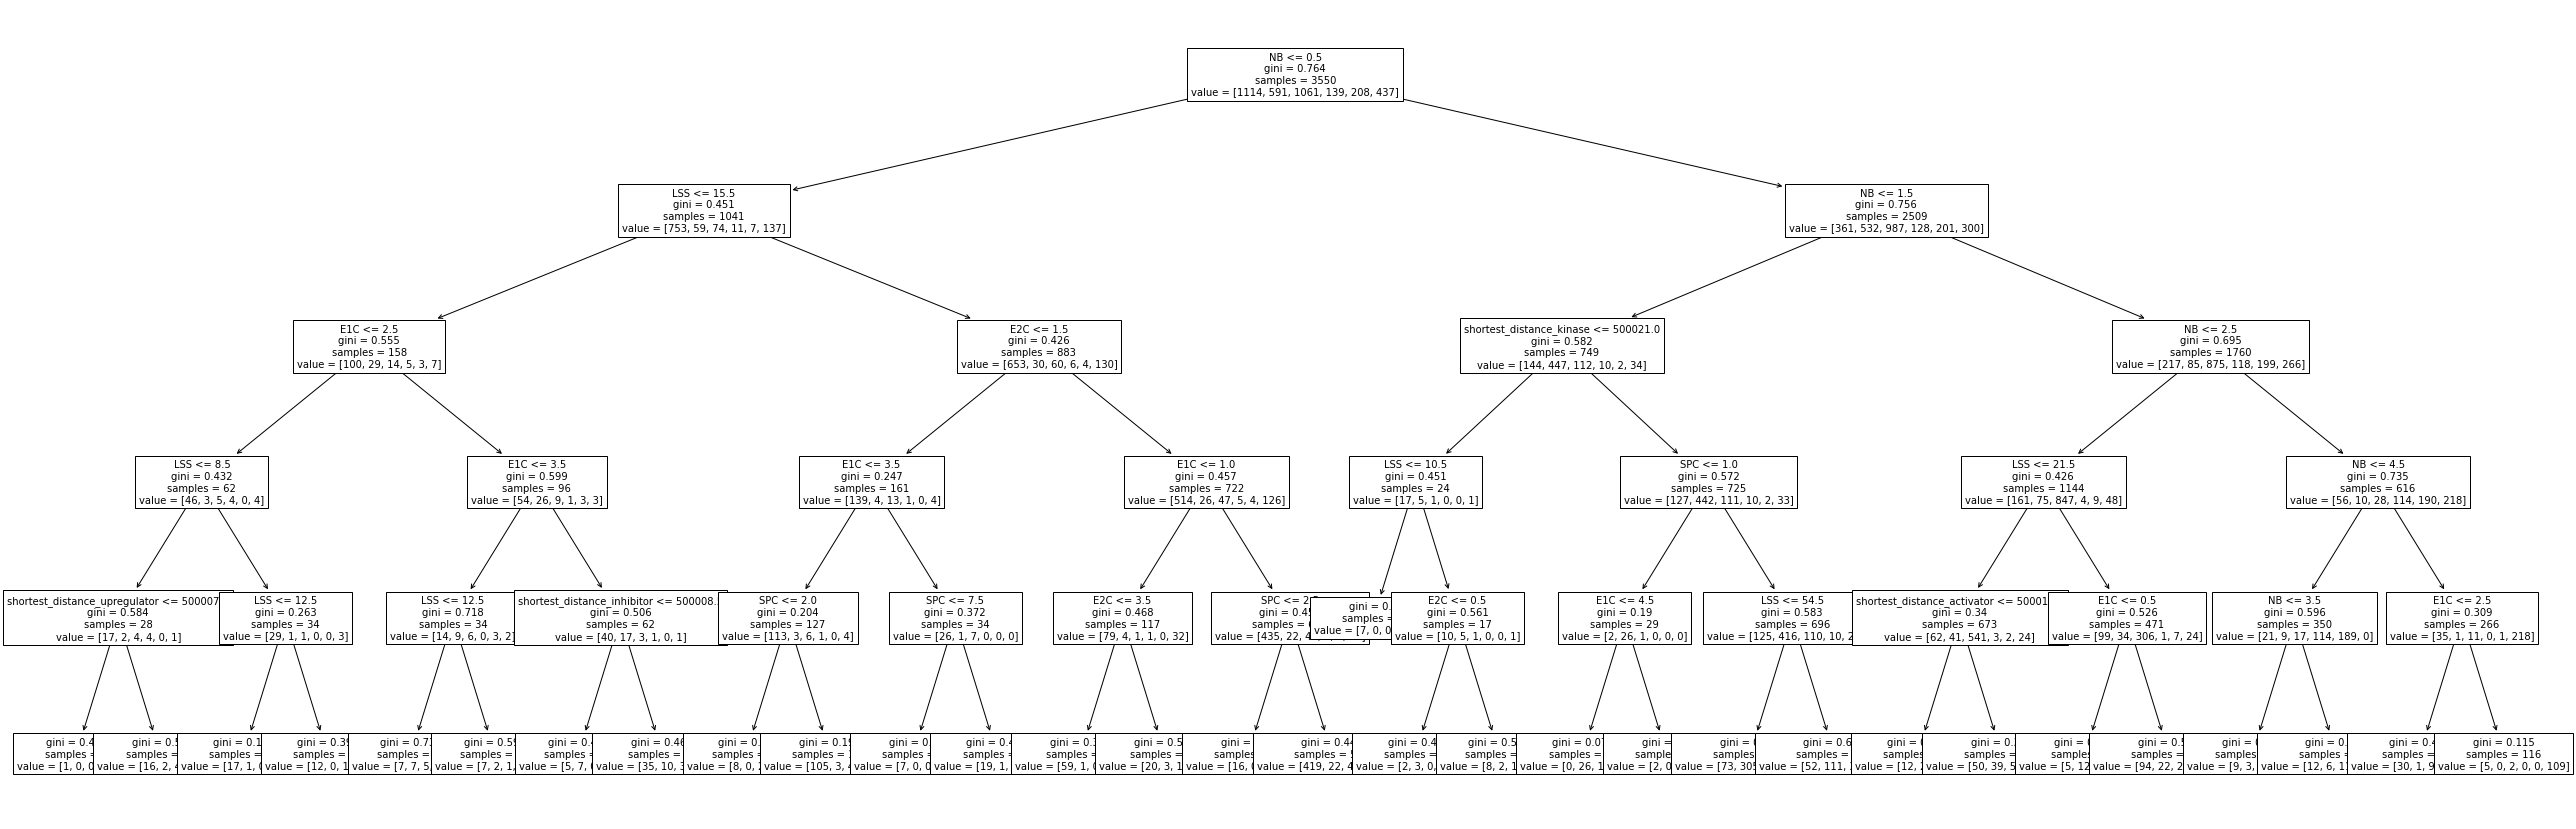

\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      72.3 &   67.6 &     69.9 &    1114 \\
       Naive Bayes &            1 &      59.7 &   75.6 &     66.7 &     591 \\
       Naive Bayes &            2 &      74.0 &   79.8 &     76.8 &    1061 \\
       Naive Bayes &            3 &      82.1 &   72.7 &     77.1 &     139 \\
       Naive Bayes &            4 &      81.5 &   88.9 &     85.1 &     208 \\
       Naive Bayes &            5 &      82.0 &   49.9 &     62.0 &     437 \\
       Naive Bayes &     accuracy &      71.9 &   71.9 &     71.9 &       0 \\
       Naive Bayes &    macro avg &      75.3 &   72.4 &     72.9 &    3550 \\
       Naive Bayes & weighted avg &      72.8 &   71.9 &     71.6 &    3550 \\
Naive Bayes + Tree &            0 &      72.7 &   69.7 &     71.1 &    1114 \\
Naive Bayes + Tree &            1 &      61.1 &   76.5 &     67.9 &     591 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.723343,0.675943,0.698840,1114.000000
1,Naive Bayes,1,0.596796,0.756345,0.667164,591.000000
2,Naive Bayes,2,0.740385,0.798303,0.768254,1061.000000
3,Naive Bayes,3,0.821138,0.726619,0.770992,139.000000
4,Naive Bayes,4,0.814978,0.889423,0.850575,208.000000
5,Naive Bayes,5,0.819549,0.498856,0.620199,437.000000
accuracy,Naive Bayes,accuracy,0.718592,0.718592,0.718592,0.718592
macro avg,Naive Bayes,macro avg,0.752698,0.724248,0.729337,3550.000000
weighted avg,Naive Bayes,weighted avg,0.728410,0.718592,0.716348,3550.000000
0,Naive Bayes + Tree,0,0.726592,0.696589,0.711274,1114.000000


In [19]:
df_val_prediction = load_valtest_pred(local_val_prediction_file)

val_prediction_result = train_and_predict_all_classifiers(df_val_prediction, min_df=1)

plot_tree(val_prediction_result[NAIVE_BAYES_WITH_TREE]["m"])



print_report_all_classifiers(df_val_prediction["y"], val_prediction_result, all_labels)

## Test 

In [20]:
df_test = load_valtest_pred(local_test_prediction_file)


print_report_original(df_test, "y_raw", test_gold_file )


Running command
java -cp ../thirdparty/bc6chemprot_eval.jar org.biocreative.tasks.chemprot.main.Main -TP TRUE -FP TRUE -FN TRUE /var/folders/7v/5_mr86mx7l9g94fxzdpdx0nw0000gn/T/tmpo0sj2oxt ../temp/data/chemprot_test_gold_standard.tsv

The file:
	./out/eval.txt
was successfully created.

The file:
	./out/tp.txt
was successfully created.

The file:
	./out/fp.txt
was successfully created.

The file:
	./out/fn.txt
was successfully created.

['\n', 'Total annotations: 3458\n', 'Total predictions: 3697\n', 'TP: 2719\n', 'FN: 739\n', 'FP: 978\n', 'Precision: 0.7354611847443874\n', 'Recall: 0.7862926547137074\n', 'F-score: 0.7600279524807828']


c,FN,FP,TP,P,R,F
y,,,,,,
CPR:3,205.0,319.0,460.0,0.590501,0.691729,0.637119
CPR:4,343.0,286.0,1318.0,0.821696,0.793498,0.807351
CPR:5,43.0,56.0,152.0,0.730769,0.779487,0.754342
CPR:6,31.0,54.0,262.0,0.829114,0.894198,0.860427
CPR:9,117.0,224.0,527.0,0.701731,0.818323,0.755556
total,739.0,939.0,2719.0,0.743302,0.786293,0.764193


In [21]:
l = 'CPR:3'
tp = df_test.query(f"y_raw=='{l}' and gold_raw=='{l}'").shape[0]
fp = df_test.query(f"y_raw=='{l}' and gold_raw!='{l}'").shape[0]
fn = df_test.query(f"y_raw!='{l}' and gold_raw=='{l}'").shape[0]


fn, fp, tp

(204, 327, 461)

In [22]:
df_test = load_valtest_pred(local_test_prediction_file)

print_report(df_test["gold"],df_test["y"], labels=pos_labels)

,precision,recall,f1-score,support
1,0.585025,0.693233,0.634549,665.0
2,0.821850,0.803398,0.812519,1648.0
3,0.727700,0.794872,0.759804,195.0
4,0.786787,0.894198,0.837061,293.0
5,0.700798,0.819596,0.755556,643.0
micro avg,0.738166,0.792393,0.764319,3444.0
macro avg,0.724432,0.801059,0.759898,3444.0
weighted avg,0.745207,0.792393,0.766623,3444.0


### Predict Test on Test GT fit

In [23]:
df_test = load_valtest_pred(local_test_prediction_file)


result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)



print_report_all_classifiers(df_test["gold"], result_test_gt, labels=pos_labels)



Training Naive Bayes
Max words :  398
Training Naive Bayes + Tree
(5703, 14)
(5703, 14)
Training Tree
(5703, 13)
(5703, 13)
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      40.2 &   63.5 &     49.2 &     665 \\
       Naive Bayes &            2 &      69.4 &   65.0 &     67.1 &    1648 \\
       Naive Bayes &            3 &      61.1 &   76.4 &     67.9 &     195 \\
       Naive Bayes &            4 &      69.0 &   75.1 &     71.9 &     293 \\
       Naive Bayes &            5 &      60.0 &   56.0 &     57.9 &     643 \\
       Naive Bayes &    micro avg &      59.2 &   64.5 &     61.7 &    3444 \\
       Naive Bayes &    macro avg &      59.9 &   67.2 &     62.8 &    3444 \\
       Naive Bayes & weighted avg &      61.5 &   64.5 &     62.4 &    3444 \\
Naive Bayes + Tree &            1 &      40.7 &   64.7 &     50.0 &     665 \\
Naive Bayes + Tree &            2 &      69.

,model,index,precision,recall,f1-score,support
1,Naive Bayes,1,0.401905,0.634586,0.492128,665.0
2,Naive Bayes,2,0.693851,0.650485,0.671469,1648.0
3,Naive Bayes,3,0.610656,0.764103,0.678815,195.0
4,Naive Bayes,4,0.689655,0.750853,0.718954,293.0
5,Naive Bayes,5,0.600000,0.559876,0.579244,643.0
micro avg,Naive Bayes,micro avg,0.591538,0.645470,0.617329,3444.0
macro avg,Naive Bayes,macro avg,0.599213,0.671981,0.628122,3444.0
weighted avg,Naive Bayes,weighted avg,0.614890,0.645470,0.624077,3444.0
1,Naive Bayes + Tree,1,0.407197,0.646617,0.499709,665.0
2,Naive Bayes + Tree,2,0.691083,0.658374,0.674332,1648.0


### Predict Test on Test Prediction fit 

Training Naive Bayes
Max words :  398
Training Naive Bayes + Tree
(5703, 14)
(5703, 14)
Training Tree
(5703, 13)
(5703, 13)


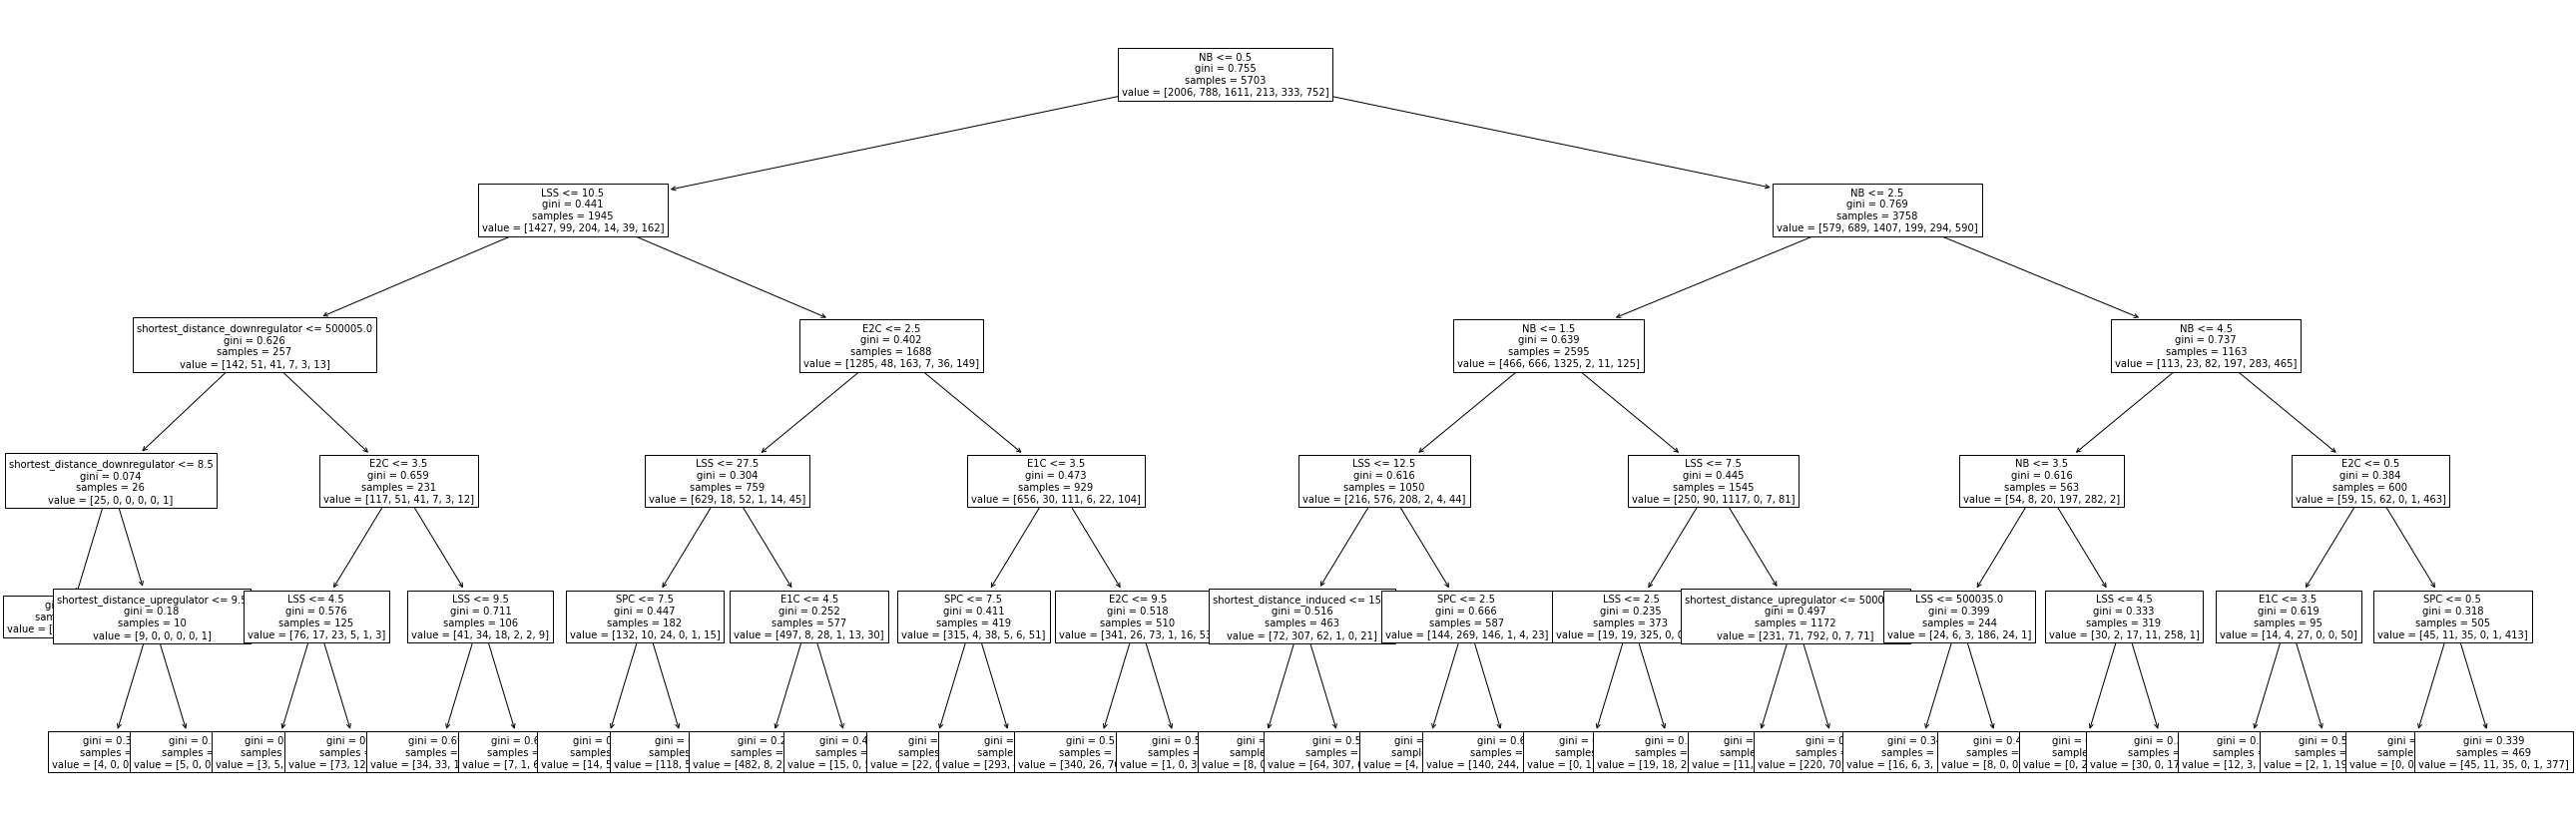

\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      54.9 &   73.1 &     62.7 &     788 \\
       Naive Bayes &            2 &      72.3 &   69.3 &     70.8 &    1611 \\
       Naive Bayes &            3 &      76.2 &   87.3 &     81.4 &     213 \\
       Naive Bayes &            4 &      80.9 &   77.5 &     79.1 &     333 \\
       Naive Bayes &            5 &      77.2 &   61.6 &     68.5 &     752 \\
       Naive Bayes &    micro avg &      69.2 &   70.3 &     69.8 &    3697 \\
       Naive Bayes &    macro avg &      72.3 &   73.8 &     72.5 &    3697 \\
       Naive Bayes & weighted avg &      70.6 &   70.3 &     70.0 &    3697 \\
Naive Bayes + Tree &            1 &      55.2 &   74.0 &     63.2 &     788 \\
Naive Bayes + Tree &            2 &      72.4 &   70.6 &     71.5 &    1611 \\
Naive Bayes + Tree &            3 &      79.8 &   87.3 &     83.4 &     213 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.733676,0.711366,0.722349,2006.000000
1,Naive Bayes,1,0.548571,0.730964,0.626768,788.000000
2,Naive Bayes,2,0.722977,0.693358,0.707858,1611.000000
3,Naive Bayes,3,0.762295,0.873239,0.814004,213.000000
4,Naive Bayes,4,0.808777,0.774775,0.791411,333.000000
5,Naive Bayes,5,0.771667,0.615691,0.684911,752.000000
accuracy,Naive Bayes,accuracy,0.706120,0.706120,0.706120,0.706120
macro avg,Naive Bayes,macro avg,0.724661,0.733232,0.724550,5703.000000
weighted avg,Naive Bayes,weighted avg,0.715541,0.706120,0.707568,5703.000000
0,Naive Bayes + Tree,0,0.739042,0.722832,0.730847,2006.000000


In [25]:
df_test_prediction = load_valtest_pred(local_test_prediction_file)

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])


print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  all_labels)




In [26]:
df_test_prediction["shortcut_pred_nbt"] = result_test_bp[NAIVE_BAYES_WITH_TREE]["predictions"]


In [27]:
print_report(df_test_prediction.query("y == gold")["y"], df_test_prediction.query("y == gold")["shortcut_pred_nbt"], all_labels)

,precision,recall,f1-score,support
0,0.783818,0.770186,0.776942,1610.000000
1,0.527897,0.800434,0.636207,461.000000
2,0.792880,0.740181,0.765625,1324.000000
3,0.823864,0.935484,0.876133,155.000000
4,0.887500,0.812977,0.848606,262.000000
5,0.810345,0.624288,0.705252,527.000000
accuracy,0.755013,0.755013,0.755013,0.755013
macro avg,0.771051,0.780592,0.768127,4339.000000
weighted avg,0.770306,0.755013,0.757700,4339.000000


In [28]:
get_top_discrimintary_keywords(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"], 5)

[('_gene_', -2.2652430920429536),
 ('_chemical_', -2.266571995893007),
 ('enzyme', -4.197960437613704),
 ('enzymes', -4.274187803001587),
 ('metabolism', -4.378448813325997),
 ('production', -4.44665706335253),
 ('mediated', -4.482589072578594),
 ('expression', -4.494859165170408),
 ('cells', -4.585243226638677),
 ('synthesis', -4.598848878694456),
 ('respectively', -4.626628442801532),
 ('il', -4.626628442801532),
 ('uptake', -4.640813077793488),
 ('transport', -4.778434455669536),
 ('type', -4.811770875937127),
 ('substrate', -4.900324273278573),
 ('inhibited', -4.919016406290725),
 ('related', -4.919016406290725),
 ('values', -4.93806460126142),
 ('activity', -4.957482687118521),
 ('10', -4.99748802173222),
 ('role', -5.018107308934956),
 ('cholesterol', -5.018107308934956),
 ('catalyzes', -5.039160718132789),
 ('study', -5.039160718132789),
 ('dependent', -5.060666923353752),
 ('human', -5.060666923353752),
 ('ic50', -5.0826458300725275),
 ('inhibition', -5.105118685924586),
 ('sub

In [29]:
pd.set_option('display.max_colwidth',None)
df_test_prediction.pipe(filter_eval).query("'NEGATIVE' == y_raw ").sample(n=10)\
[["sentence_anonymised", "y_raw", "gold_raw",  "gold", "y","shortcut_pred_nbt","relationship_type"]]

,sentence_anonymised,y_raw,gold_raw,gold,y,shortcut_pred_nbt,relationship_type
4266,"The pleiotropic effects of vitamin A are exerted mainly by one active metabolite, _CHEMICAL_ (atRA), which regulates the expression of a battery of target genes through several families of _GENE-N_ (RARs, RXRs and PPARβ/δ), polymorphic retinoic acid (RA) response elements and multiple coregulators",NEGATIVE,CPR:3,1,0,0,INDIRECT-UPREGULATOR
552,"Accordingly, docking of different _GENE-N_ inhibitors, including selective and non-selective ligands: rofecoxib, ketoprofen, suprofen, carprofen, zomepirac, indomethacin, _CHEMICAL_ and meclofenamic acid were undertaken using the AMBER program",NEGATIVE,CPR:4,2,0,0,INHIBITOR
2831,"With the pentapeptide linked through the C7alpha position of _CHEMICAL_ , the resulting PROTAC shows the most effective _GENE-N_ degradation and highest affinity for the estrogen receptor",NEGATIVE,CPR:4,2,0,0,DOWNREGULATOR
1799,Diacylglycerol ( _CHEMICAL_ ) acts as an allosteric activator of protein kinase C (PKC) and is converted to phosphatidic acid by DAG kinase ( _GENE-N_),NEGATIVE,CPR:9,5,0,1,SUBSTRATE
2207,"Various genes controlled by _CHEMICAL_ , including _GENE-Y_, anterior gradient-2, trefoil factor-1, CRP-ductin, ghrelin, and small proline-rich protein-2A, were dramatically over-expressed",NEGATIVE,CPR:3,1,0,0,INDIRECT-UPREGULATOR
4267,"The pleiotropic effects of vitamin A are exerted mainly by one active metabolite, _CHEMICAL_ (atRA), which regulates the expression of a battery of target genes through several families of nuclear receptors ( _GENE-N_, RXRs and PPARβ/δ), polymorphic retinoic acid (RA) response elements and multiple coregulators",NEGATIVE,CPR:3,1,0,0,INDIRECT-UPREGULATOR
3747,"rivaroxaban and _CHEMICAL_ , are potent, oral direct inhibitors of _GENE-N_-bound, clot-associated or free FXa",NEGATIVE,CPR:4,2,0,0,INHIBITOR
553,"Accordingly, docking of different _GENE-N_ inhibitors, including selective and non-selective ligands: rofecoxib, ketoprofen, suprofen, carprofen, zomepirac, indomethacin, diclofenac and _CHEMICAL_ were undertaken using the AMBER program",NEGATIVE,CPR:4,2,0,0,INHIBITOR
1976,"We have previously demonstrated that phosphorylation of Fas-associated death domain-containing protein (FADD) at 194 serine through _GENE-N_ (JNK) activation sensitizes breast cancer cells to chemotherapy through accelerating cell cycle arrest at G2/M, and that Bcl-2 phosphorylation downstream of JNK/FADD plays an important role in cell growth suppression by _CHEMICAL_",NEGATIVE,CPR:3,1,0,0,ACTIVATOR
4949,"_CHEMICAL_ is also a _GENE-N_ substrate, but less potent drug-drug interactions have been reported with CYP3A inhibitors",NEGATIVE,CPR:9,5,0,0,SUBSTRATE


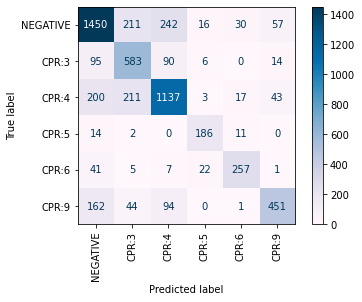

In [30]:
plot_confusionmatrix(df_test_prediction["y"], df_test_prediction["shortcut_pred_nbt"])

## Latex results

In [31]:
def prepare_latex(meta_dict_df):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.query("index == 'micro avg'").copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    
df_summ_train = print_report_all_classifiers(df_train["gold"], train_result, pos_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, pos_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["gold"], result_test_gt, pos_labels)



df_summ = prepare_latex ([
    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      46.0 &   67.8 &     54.8 &     774 \\
       Naive Bayes &            2 &      76.3 &   66.3 &     70.9 &    2251 \\
       Naive Bayes &            3 &      73.7 &   75.9 &     74.8 &     170 \\
       Naive Bayes &            4 &      69.1 &   86.9 &     77.0 &     229 \\
       Naive Bayes &            5 &      68.3 &   65.2 &     66.7 &     727 \\
       Naive Bayes &    micro avg &      66.3 &   67.9 &     67.1 &    4151 \\
       Naive Bayes &    macro avg &      66.7 &   72.4 &     68.8 &    4151 \\
       Naive Bayes & weighted avg &      68.7 &   67.9 &     67.7 &    4151 \\
Naive Bayes + Tree &            1 &      46.1 &   68.0 &     54.9 &     774 \\
Naive Bayes + Tree &            2 &      75.0 &   68.0 &     71.3 &    2251 \\
Naive Bayes + Tree &            3 &      82.4 &   74.1 &     78.0 &     170 \\
Naive Baye

In [32]:
print(len(result_test_bp[NAIVE_BAYES]["m"].vocab))

398


In [42]:
def prepare_latex(meta_dict_df):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ
    
df_summ_train = print_report_all_classifiers(df_train["gold"], train_result, all_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["gold"], result_test_gt, all_labels)



df_summ = prepare_latex ([
    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      70.9 &   67.7 &     69.2 &    2263 \\
       Naive Bayes &            1 &      46.0 &   67.8 &     54.8 &     774 \\
       Naive Bayes &            2 &      76.3 &   66.3 &     70.9 &    2251 \\
       Naive Bayes &            3 &      73.7 &   75.9 &     74.8 &     170 \\
       Naive Bayes &            4 &      69.1 &   86.9 &     77.0 &     229 \\
       Naive Bayes &            5 &      68.3 &   65.2 &     66.7 &     727 \\
       Naive Bayes &     accuracy &      67.8 &   67.8 &     67.8 &       0 \\
       Naive Bayes &    macro avg &      67.4 &   71.6 &     68.9 &    6414 \\
       Naive Bayes & weighted avg &      69.5 &   67.8 &     68.2 &    6414 \\
Naive Bayes + Tree &            0 &      72.7 &   68.1 &     70.3 &    2263 \\
Naive Bayes + Tree &            1 &      46.1 &   68.0 &     54.9 &     774 \\
Naive Baye